# 🍷

In this exercise, I analysed two datasets which are related to the Portugese Vinho Verde wine. 11 columns contain data on the physical and chemical parameters, and one column is the quality assessment by human experts. The goal is to understand the data, perform regression analysis, and produce recommendations.

Original source of this file is located in this GitHub repository, along with instructions on how to run it:  
**https://github.com/marina-kan/wine**

# 0. Set Up

In [1]:
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

In [2]:
# Notebook wide plot configuration.
custom_palette = ['#e55e62', '#d2f17f']
custom_palette_errorbar = ['#9d090d', '#58740d']
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)
plt.rcParams["font.family"] = "monospace"
wine_types = ["red", "white"]

In [3]:
# Hide Pyplot warnings.
import warnings
warnings.simplefilter('ignore', UserWarning)
warnings.simplefilter('ignore', FutureWarning)

# 1. Load Dataframes

I started by loading both red and white wine dataframes into Pandas:

In [4]:
df_red = pd.read_csv("winequality-red.csv", sep=";")
df_white = pd.read_csv("winequality-white.csv", sep=";")
print(f"There are {len(df_red)} records for red wine and {len(df_white)} records for white wine.")

There are 1599 records for red wine and 4898 records for white wine.


In [5]:
# Merge datasets.
df_red['kind'] = "red"
df_white['kind'] = "white"
df = pd.concat([df_red, df_white], ignore_index=True)

# 2. Exploratory Data Analysis

I checked if there are any missing values in the data:

In [6]:
df.isna().any().any()

False

Then I looked at summary statistics for all features:

In [7]:
df.describe().round(2)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.00,6497.00,6497.00,6497.00,6497.00,6497.00,6497.00,6497.00,6497.00,6497.00,6497.00,6497.00
mean,7.22,0.34,0.32,5.44,0.06,30.53,115.74,0.99,3.22,0.53,10.49,5.82
std,1.30,0.16,0.15,4.76,0.04,17.75,56.52,0.00,0.16,0.15,1.19,0.87
min,3.80,0.08,0.00,0.60,0.01,1.00,6.00,0.99,2.72,0.22,8.00,3.00
25%,6.40,0.23,0.25,1.80,0.04,17.00,77.00,0.99,3.11,0.43,9.50,5.00
50%,7.00,0.29,0.31,3.00,0.05,29.00,118.00,0.99,3.21,0.51,10.30,6.00
75%,7.70,0.40,0.39,8.10,0.06,41.00,156.00,1.00,3.32,0.60,11.30,6.00
max,15.90,1.58,1.66,65.80,0.61,289.00,440.00,1.04,4.01,2.00,14.90,9.00


After that, I looked at histograms (not shown) to confirm that all features, except for quality, are continuous. Because of that, I decided to use half violin plots for more informative visualisation:

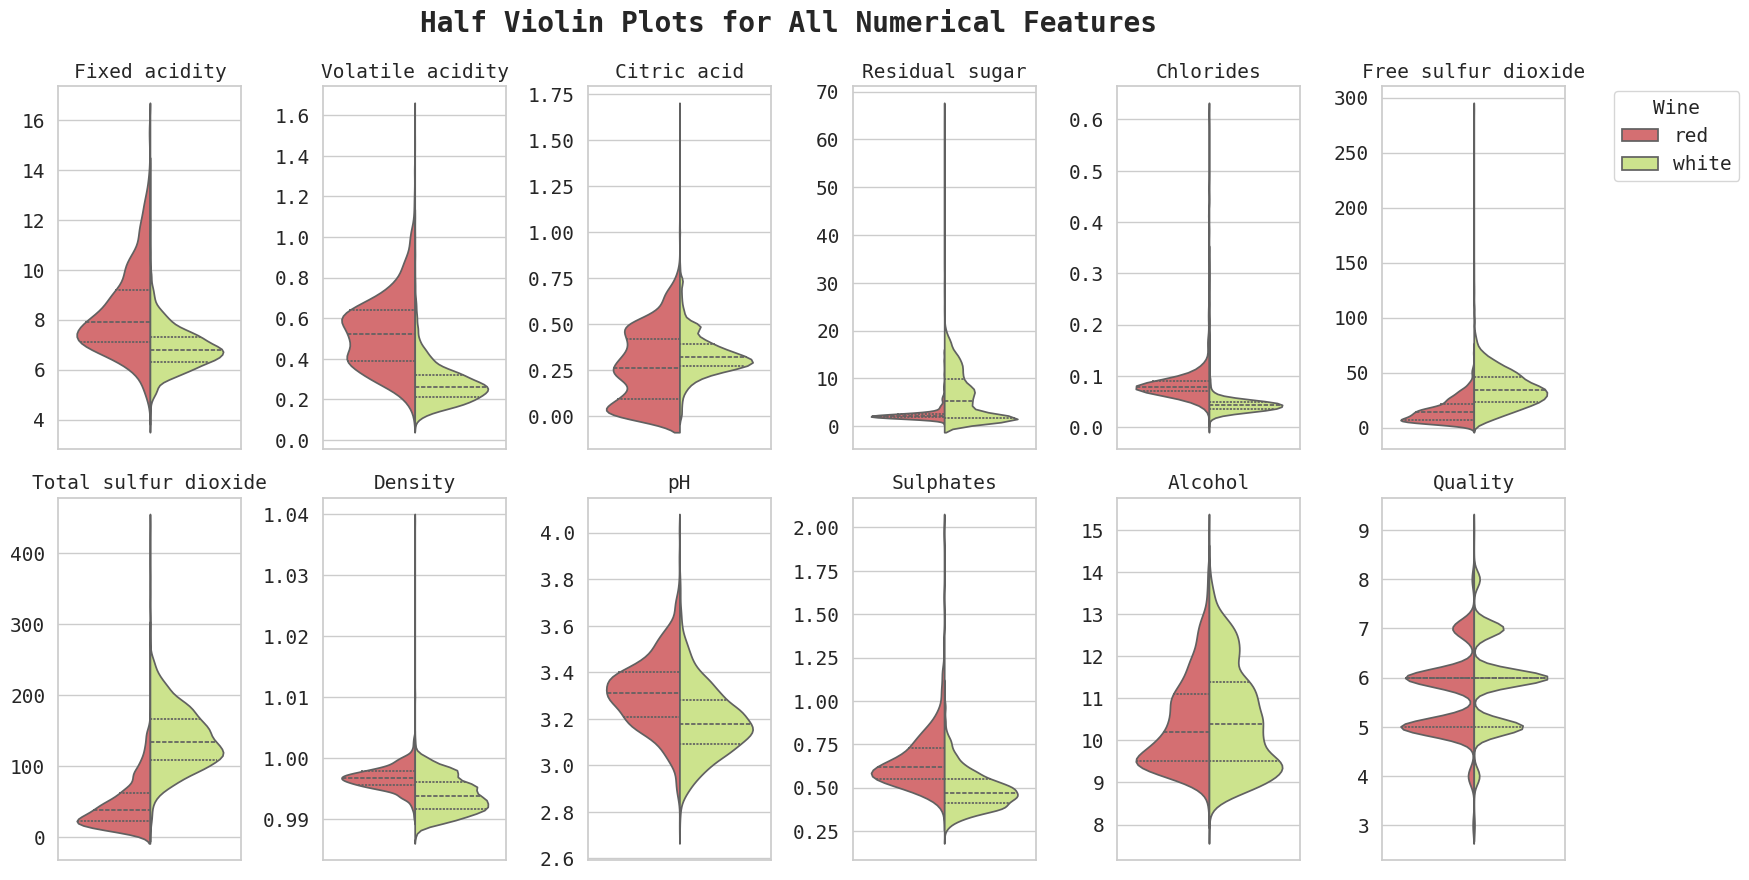

In [8]:
def half_violin_plot(df, ncols):

    # Prepare data for plotting.
    df['position'] = 0
    columns = df.drop(["kind", "position"], axis=1).columns

    # Create a grid of subplots.
    fig, axes = plt.subplots(nrows=2, ncols=ncols, figsize=(16, 9))

    # Flatten the axes array for easy iteration.
    axes = axes.flatten()

    # Iterate through the columns and create a violin plot for each.
    for i, feature in enumerate(columns):
        ax = axes[i]
        sns.violinplot(
            ax=ax, 
            data=df, 
            x="position", 
            y=feature, 
            hue="kind",
            split=True,
            inner="quart",
            palette=custom_palette,
        )
        ax.set_title(
            feature.capitalize() if feature != "pH" else feature, 
            fontdict={"fontsize": 14, "fontweight": "book"}
        )
        ax.tick_params(axis='both', which='major', labelsize=14)
        # Remove unneeded elements to make the plot more clean.
        ax.get_xaxis().set_visible(False)
        ax.set_ylabel(None)
        ax.get_legend().remove()
    df.drop('position', axis=1, inplace=True)

    # Set up legend.
    handles, labels = axes[0].get_legend_handles_labels()
    legend = fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.1, 0.9))
    legend.set_title('Wine')
    legend.get_title().set_fontsize(14)
    for text in legend.get_texts():
        text.set(fontsize=14)

    # Adjust layout.
    fig.suptitle(
        'Half Violin Plots for All Numerical Features',
        fontsize=20, fontweight="semibold"
    )
    fig.subplots_adjust(hspace=0.2)
    plt.tight_layout(rect=[0, 0, 0.999, 1])

    plt.show()
    
half_violin_plot(df, ncols=6)

The distributions of the features are relatively smooth. There aren't any obvious anomalies, although there are some outliers in most of them. Also we can see that the values of different features have different orders of magnitude.

Some features are distributed roughly the same in red and white wine, for example alcohol content and quality. Some have similar distributions, but they are shifted relative to each other, like pH and sulphates. And finally, some distributions are completely dissimilar, such as residual sugar and citric acid.

Given the nature of the features, I expect that some of them will not be independent. For example, pH, fixed acidity, volatile acidity, and citric acid are all chemically related.

# 3. Correlation Matrix

From the previous section, I observed that the distribution of features are dissimilar for red and white wine. Also, from real world experience it is a known fact that red and white wine are completely different types of drink. So it is reasonable to expect that the way experts judge them can also be quite different.

Because of the above, in all subsequent steps I decided to **analyse red and white wine separately.** This is not the only possible way to do this, but I thought it would be interesting and might provide unxpected insights.

In [9]:
# Compute the correlation matrices for red and white wine.
corr_matrix_dict = dict()
for wine in wine_types:
    corr_matrix = df[df.kind == wine].drop("kind", axis = 1).corr()
    corr_matrix_dict[wine] = corr_matrix

The correlation matrices will be visualised and analysed in the next step.

# 4. Correlation Visualisation and Analysis

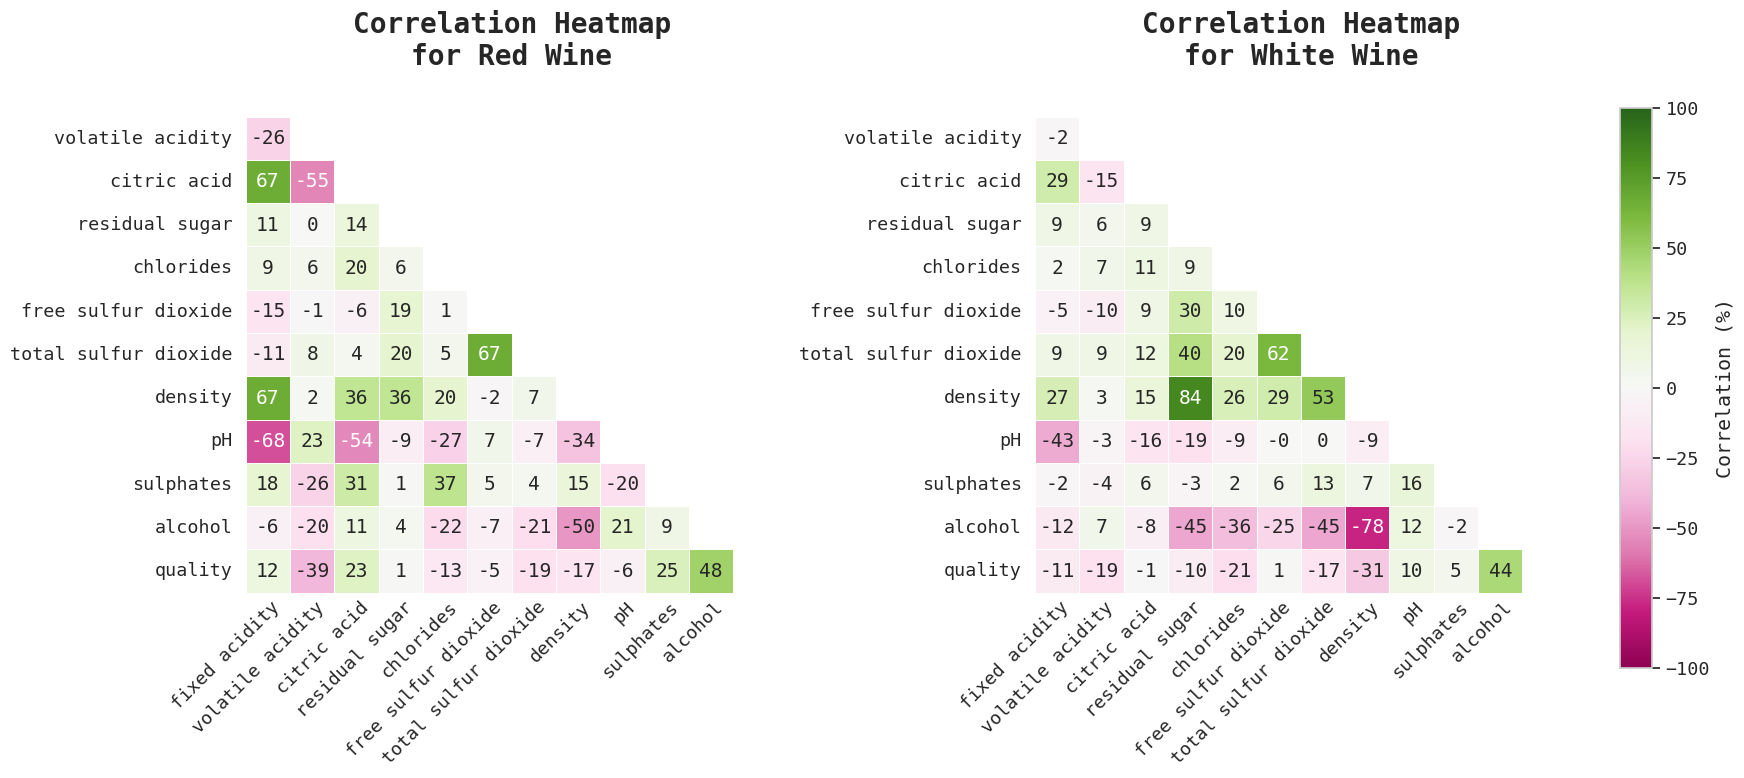

In [10]:
def plot_correlation(corr_matrix_dict):
    # Create a 1x2 grid of subplots.
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Plot the correlation heatmap.
    for i, wine in enumerate(["red", "white"]):
        ax = axes[i]
        mask = np.triu(corr_matrix_dict[wine])
        correlation_matrix = (corr_matrix_dict[wine] * 100).round()

        # Modify labels to hide them for first row and last column which have
        # no data in a triangular matrix.
        xticklabels = list(correlation_matrix.columns)
        yticklabels = xticklabels[:]
        xticklabels[-1] = ""
        yticklabels[0] = ""

        # Make the heatmap plot.
        sns.heatmap(
            ax=ax,
            data=correlation_matrix,
            annot=True,
            cmap='PiYG',
            linewidths=0.5,
            mask=mask,
            vmin=-100,
            vmax=100,
            cbar=0,
            xticklabels=xticklabels,
            yticklabels=yticklabels,
            annot_kws={"fontsize": 14}
        )
        ax.set_title(f'Correlation Heatmap\nfor {wine.capitalize()} Wine',
                     fontdict={"fontsize": 20, "fontweight": "semibold"})

        # Adjust xticks for readability.
        ax.set_xticks(
            [0.85 + i for i in range(len(xticklabels))],
            xticklabels, rotation=45, ha='right'
        )
        for tick_label in ax.get_xticklabels():
            tick_label.set_y(0.015)
        ax.grid(False)

    # Create a color bar for the entire figure.
    cbar_ax = fig.add_axes([1.02, 0.15, 0.02, 0.7])  # [x, y, width, height]
    cbar = fig.colorbar(ax.collections[0], cax=cbar_ax)
    cbar.set_label('Correlation (%)')

    # Adjust spacing between subplots.
    plt.tight_layout()

    # Show the combined heatmap.
    plt.show()

plot_correlation(corr_matrix_dict)

First of all, we can see that the correlation heatmaps look very different. This reinforces my belief that processing red and white wine separately is a good choice.

In both heatmaps, I can see that a lot of features are strongly correlated. My next goal is to minimise multicollinearity, which is especially important for OLS regression. Using _r_ threshold of around 0.5, I identified three isolated “clusters” of correlated features:

### Sulfur dioxide
Since `free sulfur dioxide` naturally seems to constitute some portion of `total sulfur dioxide`, I decided to replace it with another metric: `free sulfur dioxide norm` = `free sulfur dioxide` / `total sulfur dioxide`.

### Acidity
From reading about wine chemistry, I understand that `fixed acidity` and `volatile acidity` represent different types of acidity, while `citric acid` can be though of as part of `fixed acidity`. Also, `pH` is in a sense a measure of “total acidity” (negative logarithm of it), so it is also well correlated with the other ones. I decided to get rid of the correlations in the following way:
* Replace `citric acid` with another metric: `citric acid norm` = `citric acid` / `fixed acidity`.
* Remove pH, as it only provides the overall picture, and the other parameters describe the acidity well.

### Density 
Density is dependent on the chemical composition of the liquid, and so it is well correlated with several other features, again with different patterns for red and white wine. However, because its variation is only around 1 percentage point of the total, it's very unlikely to influence perceived wine quality. Therefore, I decided to remove the `density` feature altogether.

In [11]:
# Normalise "free sulfur dioxide".
df["free sulfur dioxide norm"] = df["free sulfur dioxide"] / df["total sulfur dioxide"]
df.drop("free sulfur dioxide", axis=1, inplace=True)

# Normalise "citric acid".
df["citric acid norm"] = df["citric acid"] / df["fixed acidity"]
df.drop("citric acid", axis=1, inplace=True)

# Remove "pH".
df.drop("pH", axis=1, inplace=True)

# Remove "density".
df.drop("density", axis=1, inplace=True)

With those feature adjustments, we run the correlation matrix again.

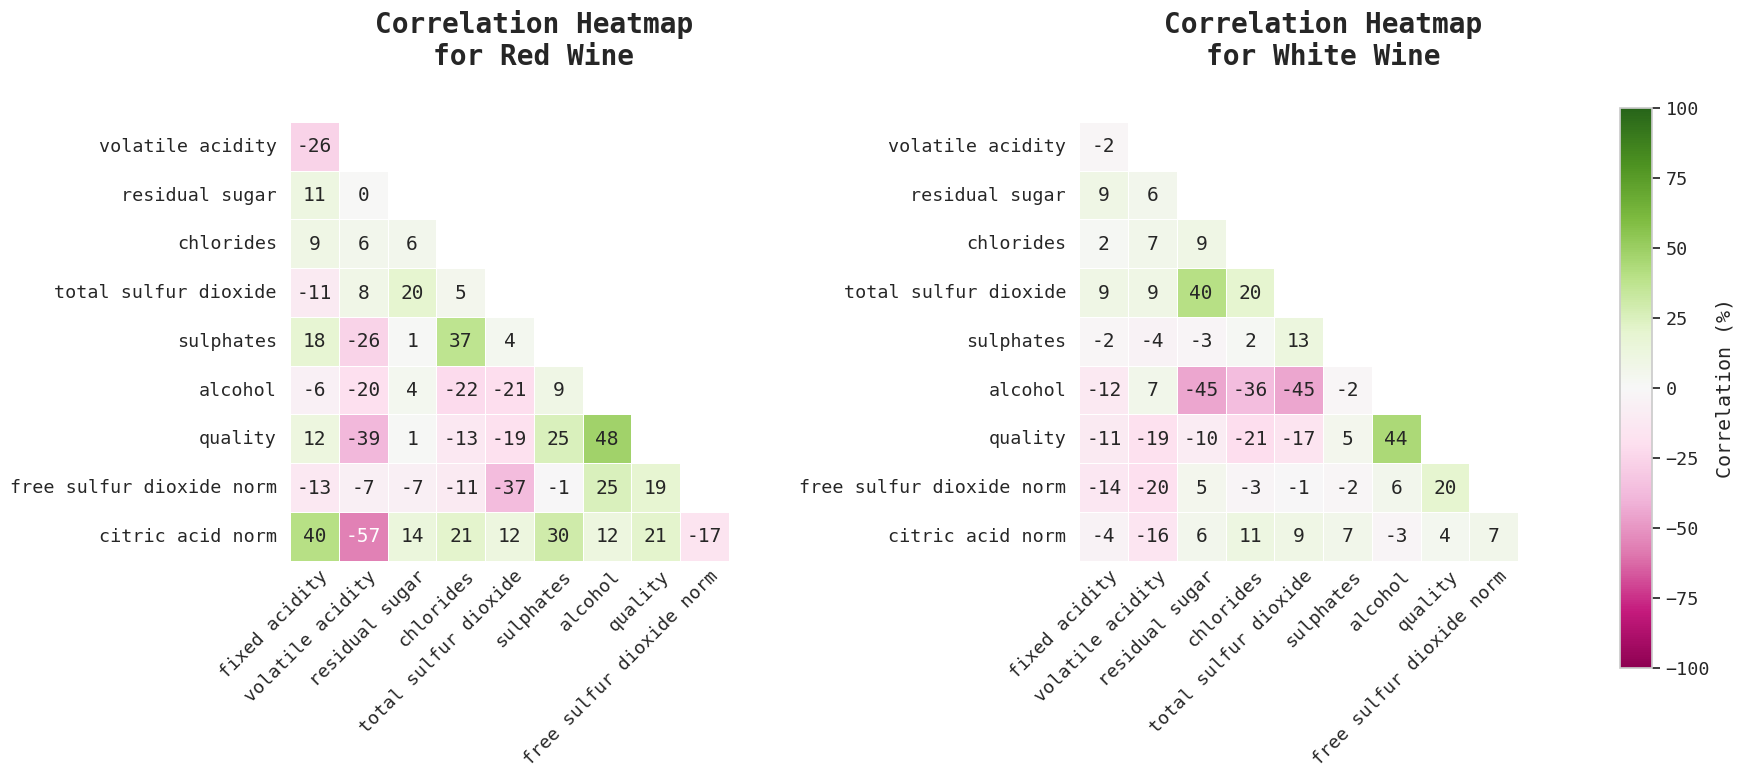

In [12]:
corr_matrix_dict_upd = dict()
for wine in wine_types:
    corr_matrix = df[df.kind == wine].drop("kind", axis = 1).corr()
    corr_matrix_dict_upd[wine] = corr_matrix
plot_correlation(corr_matrix_dict_upd)

I can see now that multicollinearity has been significantly reduced, so I can proceed to the regression step.

Also, the two added metrics show some moderate correlation with the quality parameter, which is an indication that those metrics might be useful for the regression.

# 5. Multiple Linear Regression


## 5.1. Prepare the Data

Before running multiple linear regression, it's important to prepare the data.

I decided to cap outlier values by using the Z score approach. I then scale the data using scikit-learn's `StandardScaler`, which scales the features so that they have a mean of 0 and variance of 1.

In [13]:
def prepare_data(df, kind, z_score_threshold=3):
    # Filter wine by kind, as we want to do preprocessing separately.
    df_filtered = df[df["kind"] == kind].reset_index(drop=True)

    # Calculate Z-scores for each feature, excluding the specified columns, and cap the outliers.
    df_capped = df_filtered.drop(["kind", "quality"], axis=1)
    z_scores = df_capped.apply(lambda col: np.abs((col - col.mean()) / col.std()))
    df_capped = df_capped.apply(lambda col: col.clip(
        lower=col.mean() - z_score_threshold * col.std(),
        upper=col.mean() + z_score_threshold * col.std()
    ))

    # Scale the features.
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_capped), columns=df_capped.columns)

    # Add back the quality and kind columns.
    df_scaled["quality"] = df_filtered["quality"]
    df_scaled["kind"] = df_filtered["kind"]
    return df_scaled

df_red, df_white = prepare_data(df, "red"), prepare_data(df, "white")
df = pd.concat([df_red, df_white], ignore_index=True)

We can now check how the features look like after preparation:

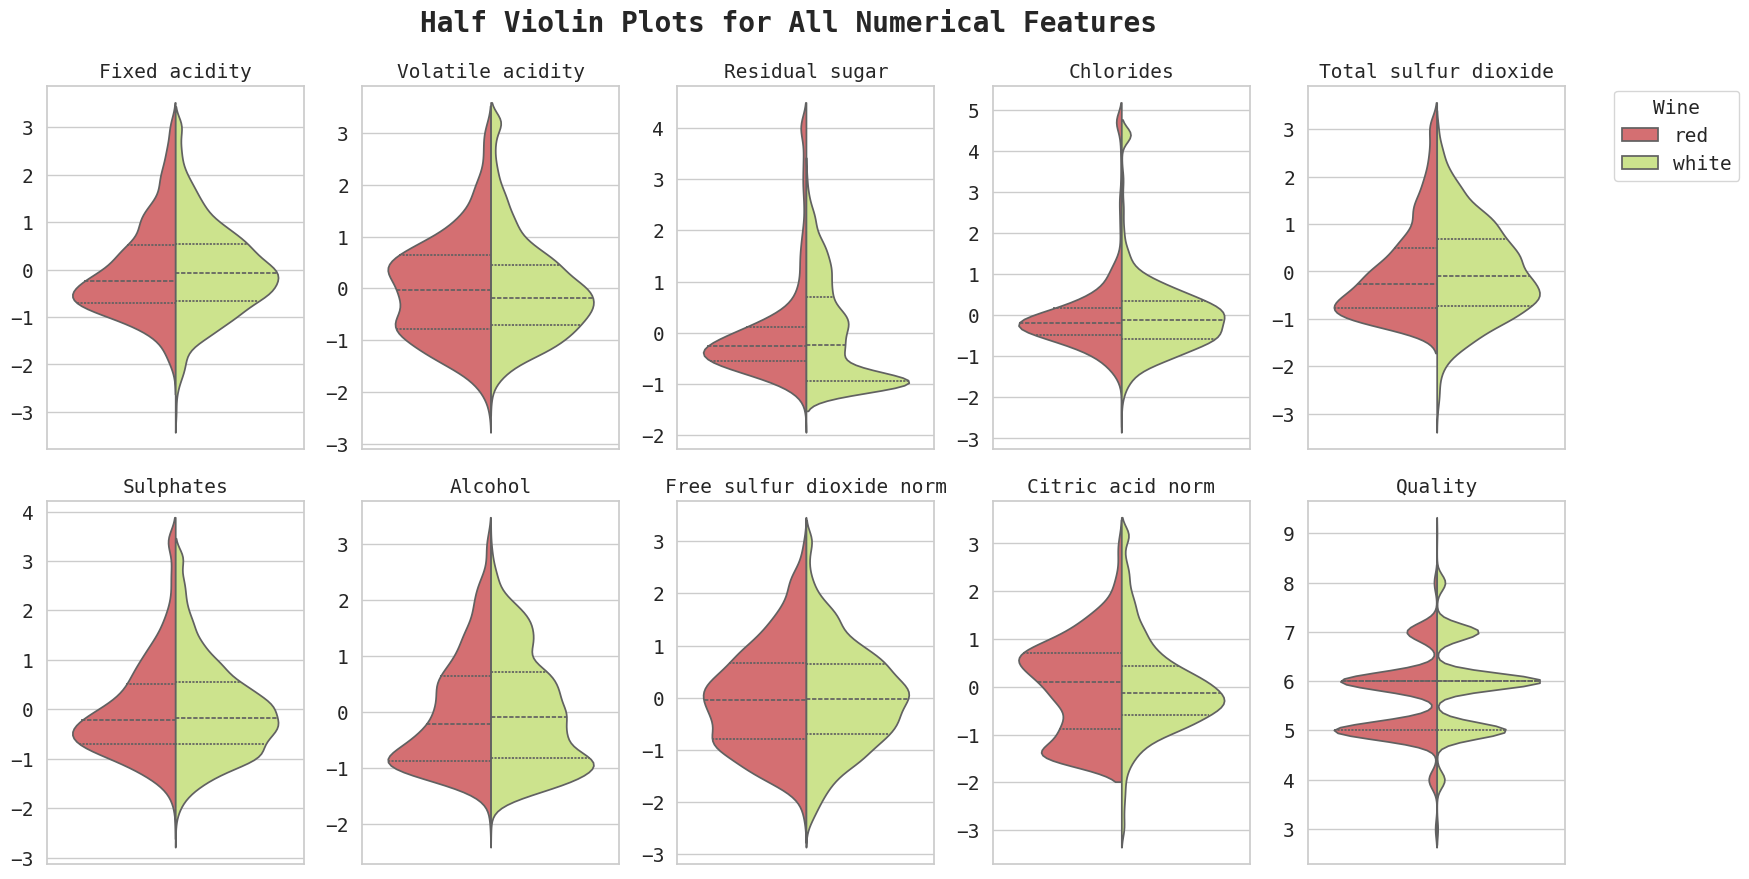

In [14]:
half_violin_plot(df, ncols=5)

## 5.2. Split Into Training and Validation Sets

Because many regression models are prone to overfitting, it's extremely important to separate the data into training and validation sets. Only the training set is exposed to the model, and we can then check the performance on the validation set using various performance metrics.

I am using stratified splitting, which should give more robust results.

In [15]:
def split_dataset(input_df, test_size=0.30):
    X = input_df.drop(columns=["quality", "kind"], axis=1)
    y = input_df["quality"]
    
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)

    for train_index, val_index in sss.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    X_train.reset_index(drop=True, inplace=True)
    X_val.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    y_val.reset_index(drop=True, inplace=True)
    return X_train, X_val, y_train, y_val

In [16]:
X_train_red, X_val_red, y_train_red, y_val_red = (
    split_dataset(df[df["kind"] == "red"].reset_index(drop=True))
)
X_train_white, X_val_white, y_train_white, y_val_white = (
    split_dataset(df[df["kind"] == "white"].reset_index(drop=True))
)

In [17]:
def linear_regression(X_train, X_val, y_train, y_val):
    # Add a constant term to the independent variables.
    X_train = sm.add_constant(X_train)
    X_val = sm.add_constant(X_val)

    # Fit the multiple regression model.
    model = sm.OLS(y_train, X_train).fit()
    
    # Get the regression training summary.
    summary = model.summary()
    display(summary.tables[0])
    display(summary.tables[1])
    
    # Run predictions for the validation set.
    y_pred = model.predict(X_val)

    # Evaluate the model with the R2 metric.
    r2 = r2_score(y_val, y_pred)
    
    print(f"Prediction R-squared: {r2:.3f}")
    return summary, model

## 5.3. Linear Regression for Red Wine

In [18]:
summary_red, model_red = linear_regression(X_train_red, X_val_red, y_train_red, y_val_red)

Dep. Variable:,quality,R-squared:,0.352
Model:,OLS,Adj. R-squared:,0.346
Method:,Least Squares,F-statistic:,66.80
Date:,"Sun, 08 Oct 2023",Prob (F-statistic):,4.48e-98
Time:,23:15:18,Log-Likelihood:,-1107.2
No. Observations:,1119,AIC:,2234.
Df Residuals:,1109,BIC:,2285.
Df Model:,9,,
Covariance Type:,nonrobust,,


,coef,std err,t,P>|t|,[0.025,0.975]
const,5.6345,0.020,287.997,0.000,5.596,5.673
fixed acidity,0.0502,0.023,2.173,0.030,0.005,0.096
volatile acidity,-0.1898,0.026,-7.265,0.000,-0.241,-0.139
residual sugar,0.0002,0.021,0.012,0.990,-0.040,0.041
chlorides,-0.0473,0.022,-2.128,0.034,-0.091,-0.004
total sulfur dioxide,-0.0513,0.023,-2.257,0.024,-0.096,-0.007
sulphates,0.1354,0.022,6.265,0.000,0.093,0.178
alcohol,0.2950,0.023,12.925,0.000,0.250,0.340
free sulfur dioxide norm,0.0620,0.022,2.770,0.006,0.018,0.106
citric acid norm,-0.0341,0.028,-1.198,0.231,-0.090,0.022


Prediction R-squared: 0.380


## 5.4. Linear Regression for White Wine

In [19]:
summary_white, model_white = linear_regression(X_train_white, X_val_white, y_train_white, y_val_white)

Dep. Variable:,quality,R-squared:,0.284
Model:,OLS,Adj. R-squared:,0.282
Method:,Least Squares,F-statistic:,150.9
Date:,"Sun, 08 Oct 2023",Prob (F-statistic):,1.20e-240
Time:,23:15:18,Log-Likelihood:,-3875.9
No. Observations:,3428,AIC:,7772.
Df Residuals:,3418,BIC:,7833.
Df Model:,9,,
Covariance Type:,nonrobust,,


,coef,std err,t,P>|t|,[0.025,0.975]
const,5.8786,0.013,458.364,0.000,5.853,5.904
fixed acidity,-0.0467,0.013,-3.586,0.000,-0.072,-0.021
volatile acidity,-0.1928,0.014,-13.977,0.000,-0.220,-0.166
residual sugar,0.1261,0.015,8.369,0.000,0.097,0.156
chlorides,-0.0383,0.015,-2.620,0.009,-0.067,-0.010
total sulfur dioxide,0.0192,0.015,1.258,0.208,-0.011,0.049
sulphates,0.0572,0.013,4.371,0.000,0.032,0.083
alcohol,0.4445,0.017,25.851,0.000,0.411,0.478
free sulfur dioxide norm,0.0858,0.013,6.452,0.000,0.060,0.112
citric acid norm,0.0100,0.013,0.757,0.449,-0.016,0.036


Prediction R-squared: 0.261


# 6. Interpreting Linear Regression Results

After training the OLS regression model, we can look at some metrics in the provided summary. 

## 6.1. _r<sup>2</sup>_ Metric

This metric, also called the coefficient of determination, has a nice intuitive interpretation: proportion of variation of the dependent variable which is explained by the model. So the maximum it can be is 1.0, and the higher it is, the better.

It is reported as **0.352** for red wine and **0.284** for white wine. This means that the OLS regression works better for red wine, in the sense that it can explain more of the variation of quality based on the measured features.

However, it's very important to note that this was estimated using the training process. The proper way to evaluate models is running predictions on test data and computing the _r<sup>2</sup>_ then. Computed in this way, the metric is **0.380** for red wine and **0.261** for white wine.


## 6.2. Coefficients and p-values

We also have look at several other metrics in the regression summary output:
* `coef` tells us the contribution of each feature to the overall regression equasion. Because we scaled the features before the analysis, we can compare the coefficients to estimate which features are more important for the prediction.
* `std err`, and the associated confidence interval (`[0.025 ... 0.975`), provide a statistically likely range for the possible values of the coefficient (as `coef` is just the model's best guess).
* `t` and the computed P-value (`P>|t|`) provide the results of the statistical significance test. The null hypothesis is that the feature _does not_ contribute to the predicted quality value. The `P>|t|` is the probability that the null hypothesis is correct, that is, that the feature indeed does not contribute. The lower it is, the more likely is that the effect of the feature is statistically significant.

## 6.3. Feature Contributions

We can visualise the confidence interval for each feature:

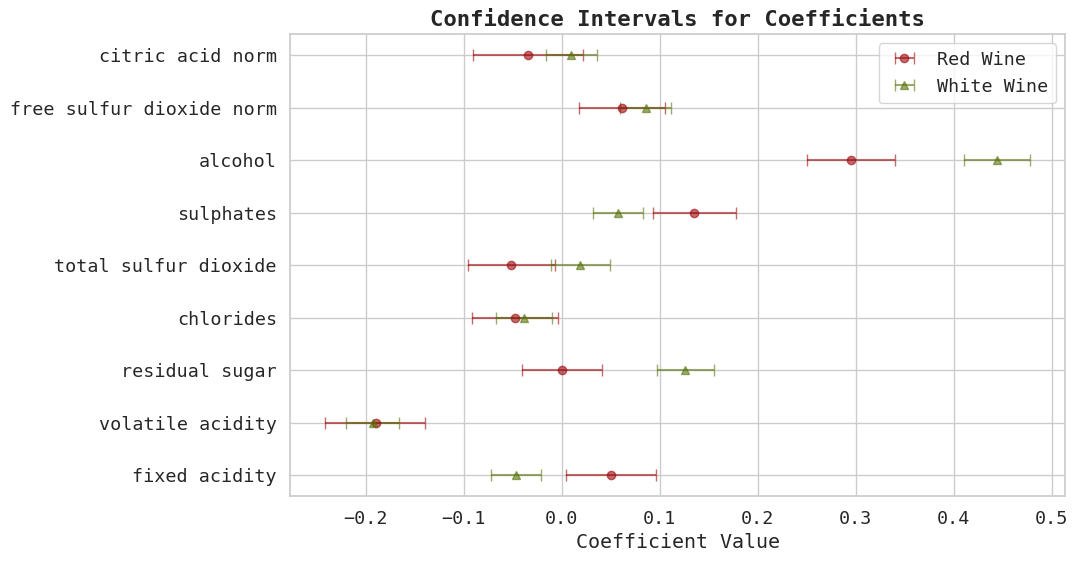

In [20]:
# Create a figure for the plots.
fig, ax = plt.subplots(figsize=(10, 6))

# Function to extract confidence intervals from the summary object.
def extract_ci(summary):
    # Slightly ugly hack, but this is the quickest way I found to convert
    # SimpleTable into Pandas dataframe...
    summary_df = (
        pd.read_html(summary.tables[1].as_html(), header=0, index_col=0)[0].drop("const")
    )
    ci = summary_df[['[0.025', '0.975]']]
    ci.columns = ['Lower', 'Upper']
    return ci

data = (
    ("red", summary_red, model_red, custom_palette_errorbar[0], "o"),
    ("white", summary_white, model_white, custom_palette_errorbar[1], "^")
)

for wine, summary, model, colour, marker_fmt in data:
    # Get confidence intervals for coefficients from the summary objects.
    ci = extract_ci(summary)
    # Extract the coefficients and their names. Drop const.
    coefficients = model.params[1:]
    # Plot the confidence intervals.
    plt.errorbar(
        coefficients,
        range(len(coefficients)),
        xerr=(coefficients - ci['Lower'], ci['Upper'] - coefficients),
        fmt=marker_fmt,
        label=f"{wine.capitalize()} Wine",
        color=colour,
        uplims=True,
        lolims=True,
        capsize=4,
        alpha=0.6,
    )

# Customize the plot
plt.yticks(range(len(coefficients)), ci.index)
plt.xlabel('Coefficient Value')
plt.title('Confidence Intervals for Coefficients', fontweight="semibold", fontsize=16)
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

# 7. Conclusions and Recommendations
1. Regression results seem to confirm the initial hypothesis that red wine and white wine are quite different in which factors determine their quality and taste. So I can recommend to continue using separate models to predict wine quality.
2. Linear regression provides at best moderate results for this task. It explains **38%** of variability in red wine quality marks, and only **26%** for white wine.
3. For both wines, **alcohol** content is the single most important feature predicting their perceived quality, with OLS regression coefficients around 30% for red wine and 50% for white wine. This aligns with real world perception that alcohol makes the wine taste more full and rich, and low alcohol wines can be perceived as flat.
4. The second most important feature for both wines is **volatile acidity**, giving negative contribution with coefficient around –19% for both. This is also supported by the real world fact that most of the volatile acidity in wine is caused by acetic acid, which can give wine an unpleasant vinegar like smell.
5. Several minor features behave similarly for both wine types:
      - Positive: free sulfur dioxide (normalised), sulphates;
      - Negative: chlorides.
6. Several features in both wine types have either no significant effect, or very small effect bordering on significance: citric acid (normalised), total sulfur dioxide.
7. Interestingly, two minor features behave differently between red and white wine:
      - **residual sugar:** no effect for red, moderate positive effect for white;
      - **fixed acidity**: small positive effect for red (although confidence interval is wide), small negative effect for white.

## Additional notes
* It is likely that non-linear relationships can exist in the data, and the model isn't able to explain all of them. So it would be advisable to look beyond simple OLS models (this is tested below).
* Interestingly enough, despite the quality scale goes from 0 to 10 inclusive, almost all of the median quality marks are either 5, 6, or 7. Potentially, instead of regression, a classification approach could be used in the future (this has not been tested).
* It's been mentioned that the dataset describes Portugese Vinho Verde wines. Because of that, the approach or any conclusions should not be applied to other types of wine without additional validation.

# 8. Bonus: Random Forest

This wasn't part of the technical test, but I was very interested to see if a more complex model can fit the data better. So I ran the Random Forest classifier and compared the results with OLS:

In [21]:
def random_forest(X_train, X_val, y_train, y_val): 
    model_forest = RandomForestRegressor(n_estimators=200, random_state=42)
    model_forest.fit(X_train, y_train)
    y_pred = model_forest.predict(X_val)

    # Calculate the R2 metric.
    r2 = r2_score(y_val, y_pred)
    
    return r2, model_forest.feature_importances_

In [22]:
def feature_importance_bar(wine, features, feature_names):
    # Create a dataframe with feature names and their importance scores.
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': features})

    # Sort the dataframe by importance score.
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Create a bar plot.
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Feature Name')
    plt.title(f'Feature Importance Plot for {wine.capitalize()} Wine', fontweight="semibold", fontsize=16)
    plt.show()

# Get the names of the features.
feature_names = X_train_red.columns  

In [23]:
def calculate_and_plot_random_forest(wine, X_train, X_val, y_train, y_val):
    r2, feature_importances = random_forest(X_train, X_val, y_train, y_val)
    feature_importance_bar(wine, feature_importances, feature_names)
    print(f"Prediction R-squared: {r2:.3f}")

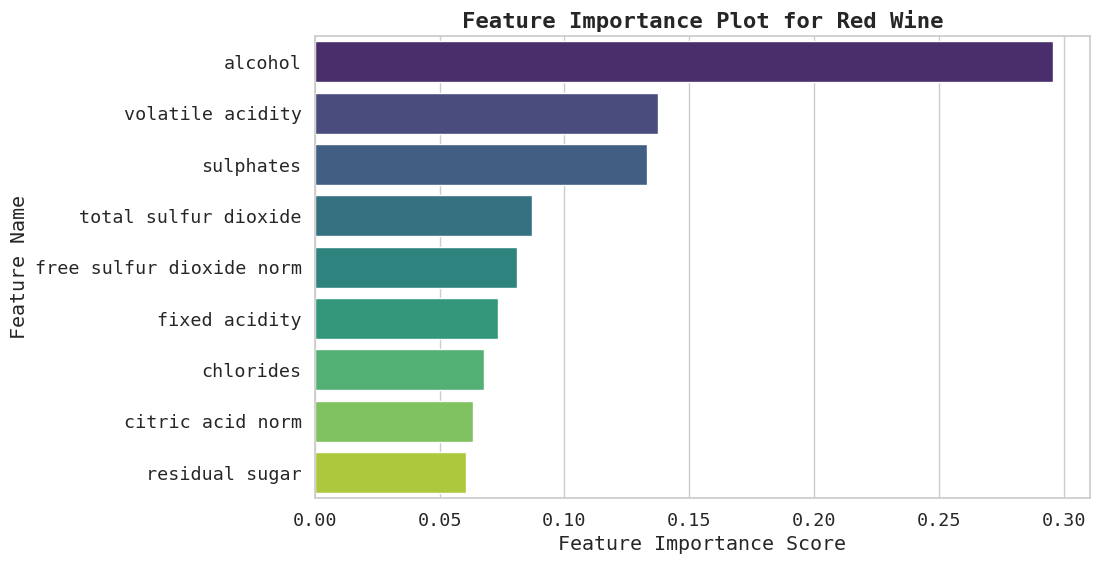

Prediction R-squared: 0.484


In [24]:
calculate_and_plot_random_forest("red", X_train_red, X_val_red, y_train_red, y_val_red)

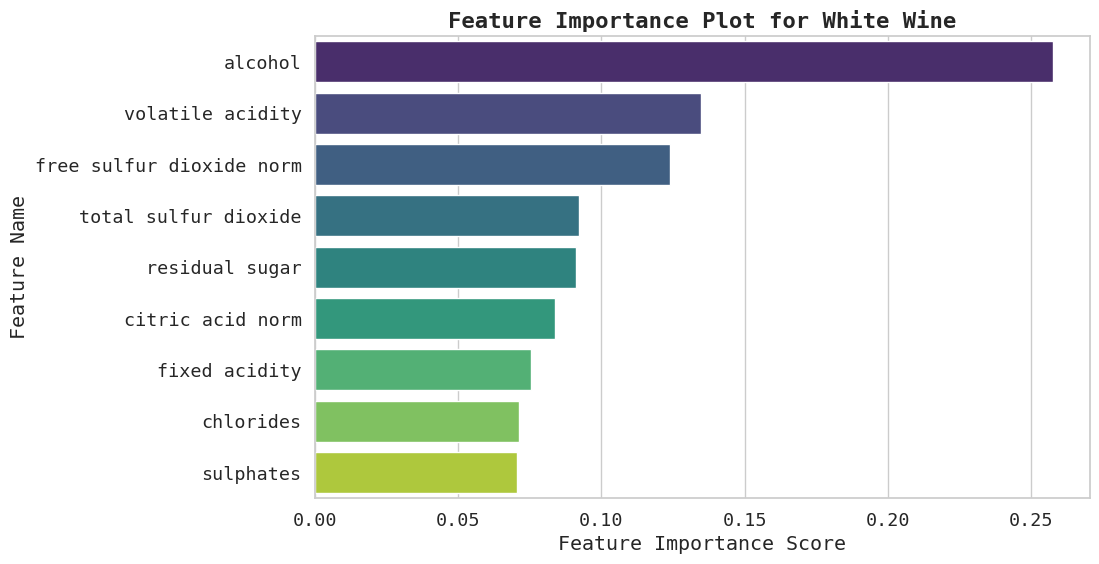

Prediction R-squared: 0.514


In [25]:
calculate_and_plot_random_forest("white", X_train_white, X_val_white, y_train_white, y_val_white)

Clearly, Random Forest deals much better with this data than OLS. For red wine, _r<sup>2</sup>_ has changed from 38% to 48% — 10 percentage points gain. And for white wine, _r<sup>2</sup>_ changed from a mere 26% to 51% — a very impressive 25 percentage points gain! Visualised:

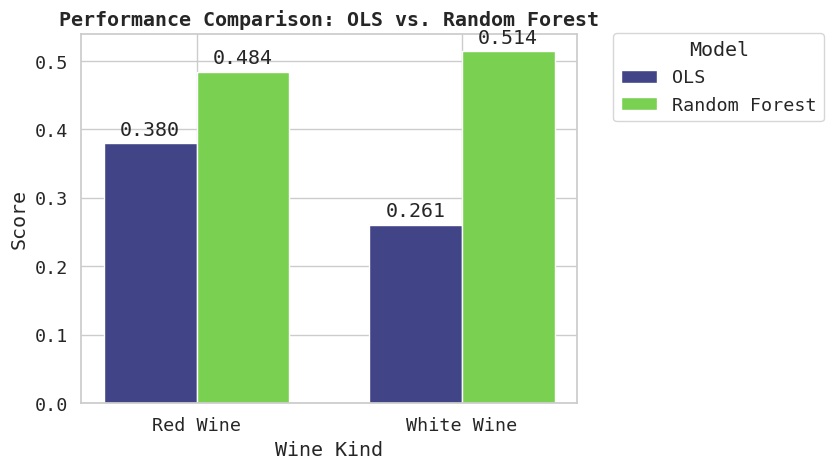

In [26]:
# Data
wine_types = ['Red Wine', 'White Wine']
ols_scores = [0.380, 0.261]
rf_scores = [0.484, 0.514]

# Create bar chart
width = 0.35
x = range(len(wine_types))

cmap = plt.get_cmap("viridis")
fig, ax = plt.subplots()
rects1 = ax.bar(x, ols_scores, width, label='OLS', color=cmap(0.2))
rects2 = ax.bar(
    [i + width for i in x],
    rf_scores,
    width,
    label='Random Forest', color=cmap(0.8)
)

# Add labels, title, and legend outside the plot
ax.set_xlabel('Wine Kind')
ax.set_ylabel('Score')
ax.set_title('Performance Comparison: OLS vs. Random Forest', fontweight="demibold")
ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(wine_types)

# Add scores above the bars
def add_scores(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

add_scores(rects1)
add_scores(rects2)
legend = fig.legend(loc='upper right', bbox_to_anchor=(1.3, 0.9))
legend.set_title('Model')

plt.show()

Interestingly enough, feature importances changed compared with the OLS model. **Alcohol** is still the most important predictor for both types of wine, and **volatile acidity** is still the second most important. However, the third most important feature, giving almost the same contribution as volatile acidity, is now different for two types of wine:
* For red wine, sulphates are important;
* And for white wine, it's free sulphur dioxide (normalised metric).

## Final Notes

I wanted to add that while I tried several other models, such as Gradient Boosting Regressor, SVR, and neural networks, none of them managed to exceed performance of this Random Forest model. (But many were nearly as good as Random Forest.)

Given the Random Forest is fast, robust, and versatile, in production I would probably lean towards using it to approach this problem.